Fitting 3 folds for each of 2 candidates, totalling 6 fits
Confusion Matrix:
 [[24191     0     2]
 [    3   114     0]
 [    1     0  9262]]

Classification Report:
               precision    recall  f1-score   support

        None       1.00      1.00      1.00     24193
        Fast       1.00      0.97      0.99       117
        Slow       1.00      1.00      1.00      9263

    accuracy                           1.00     33573
   macro avg       1.00      0.99      1.00     33573
weighted avg       1.00      1.00      1.00     33573

Macro F1 Score: 0.9955756878298815
Weighted F1 Score: 0.9998207108224204


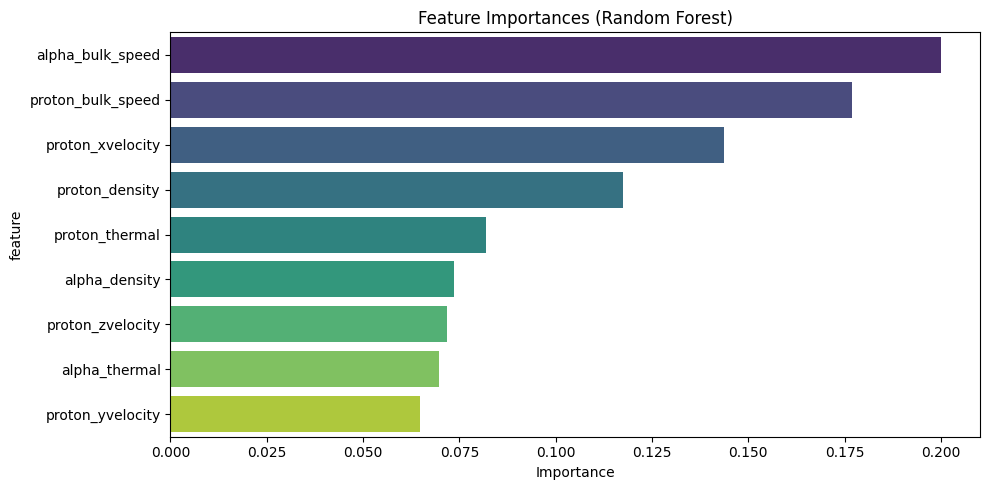

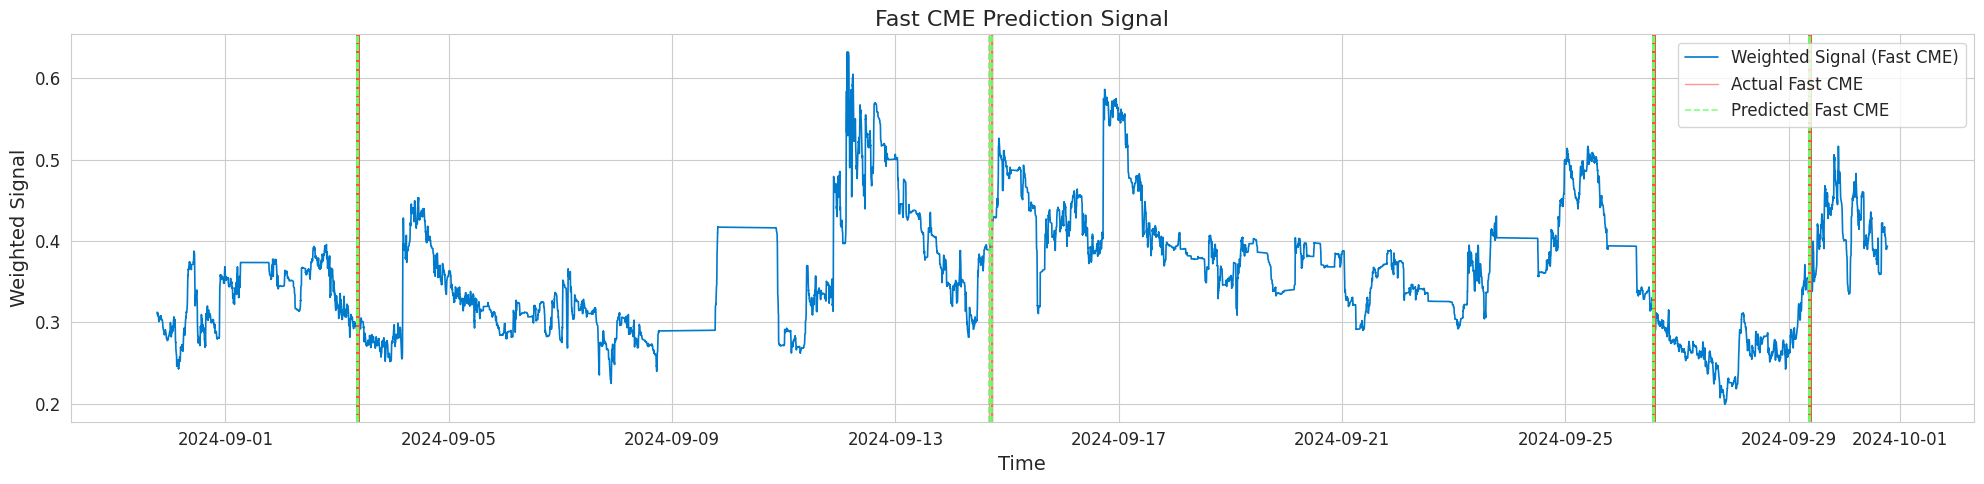

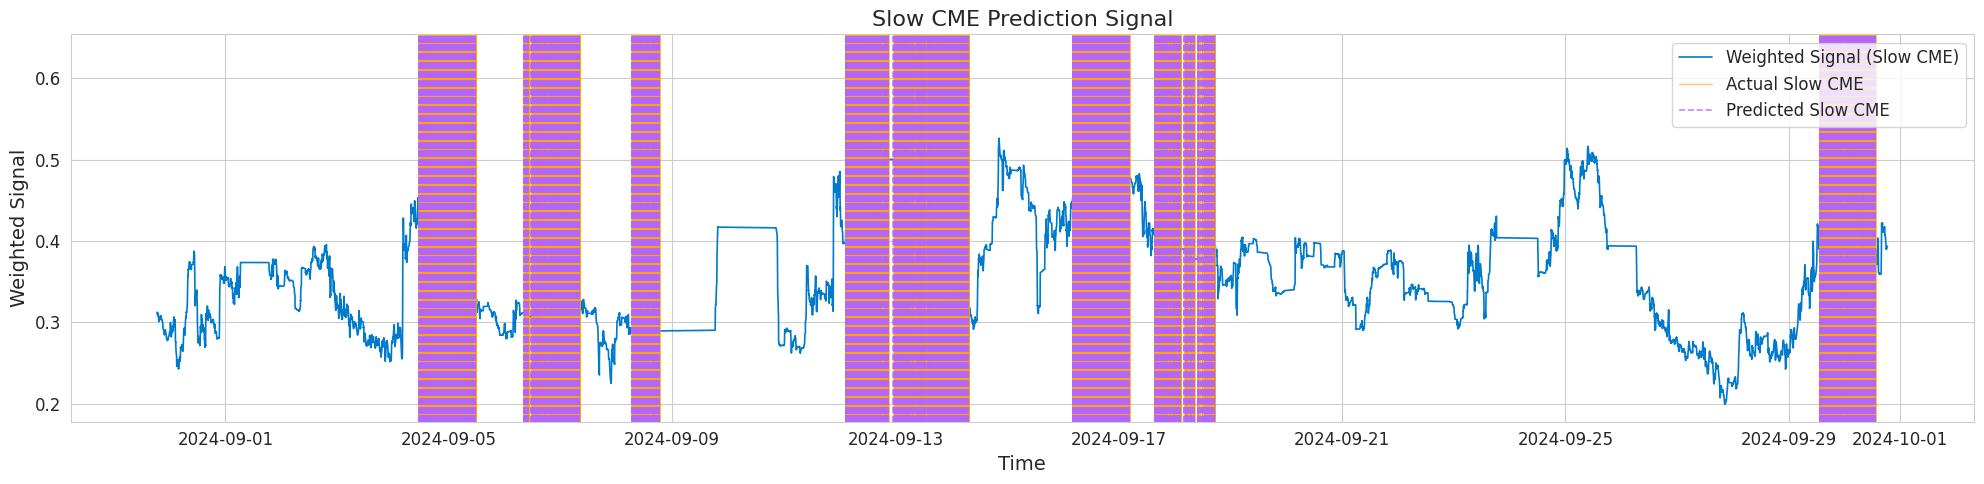

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from Scripts.model import train_cme_prediction_model
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Scripts.Bulkparameters import load_blk_variables

data = load_blk_variables('../data/BLK/*.cdf', -1e31)

# Load CACTus CME times (you can extract these from the raw text using your parser)
from Scripts.cactusHandler import parse_cactus_file
cme_times = parse_cactus_file('../data/cmecat.txt')

df,model, weights = train_cme_prediction_model(data,cme_times, 0.2)

features = [
    'proton_density',
    'proton_bulk_speed',
    'proton_thermal',
    'alpha_density',
    'alpha_bulk_speed',
    'alpha_thermal' , 
    'proton_xvelocity',
    'proton_yvelocity' ,
    'proton_zvelocity'
]

# Step 1: Compute signal using weights for "fast CME" class (class 1)
fast_class_index = 1  # class 0 = no CME, 1 = fast, 2 = slow
feature_cols = [col for col in df.columns if col not in ['time', 'cme_label', 'cme_pred', 'cme_proba']]
signal = sum(
    weights[feature] * df[feature]
    for feature in feature_cols
)

import seaborn as sns
import matplotlib.pyplot as plt

# Sort features by importance
sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_weights)
df_importance = pd.DataFrame({'feature': features, 'importance': importances})

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_importance,
    x='importance',
    y='feature',
    hue='feature',
    palette='viridis',
    legend=False
)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Step 2: Plotting
import matplotlib.dates as mdates
import seaborn as sns

# Set Seaborn style for aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "figure.titlesize": 18
})

# Colors
signal_color = '#007acc'
actual_fast_color = '#ff4d4d'
predicted_fast_color = '#66ff66'
actual_slow_color = '#ffa500'
predicted_slow_color = '#b266ff'

# === FAST CME Plot ===
plt.figure(figsize=(20, 5))
plt.plot(df['time'], signal, label='Weighted Signal (Fast CME)', linewidth=1.2, color=signal_color)

# Actual Fast CME
for idx, t in enumerate(df[df['cme_label'] == 1]['time']):
    plt.axvline(x=t, color=actual_fast_color, linestyle='-', linewidth=1.0, alpha=0.6,
                label='Actual Fast CME' if idx == 0 else "")

# Predicted Fast CME
for idx, t in enumerate(df[df['cme_pred'] == 1]['time']):
    plt.axvline(x=t, color=predicted_fast_color, linestyle='--', linewidth=1.2, alpha=0.8,
                label='Predicted Fast CME' if idx == 0 else "")

plt.title("Fast CME Prediction Signal")
plt.xlabel("Time")
plt.ylabel("Weighted Signal")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# === SLOW CME Plot ===
plt.figure(figsize=(20, 5))
plt.plot(df['time'], signal, label='Weighted Signal (Slow CME)', linewidth=1.2, color=signal_color)

# Actual Slow CME
for idx, t in enumerate(df[df['cme_label'] == 2]['time']):
    plt.axvline(x=t, color=actual_slow_color, linestyle='-', linewidth=1.0, alpha=0.6,
                label='Actual Slow CME' if idx == 0 else "")

# Predicted Slow CME
for idx, t in enumerate(df[df['cme_pred'] == 2]['time']):
    plt.axvline(x=t, color=predicted_slow_color, linestyle='--', linewidth=1.2, alpha=0.8,
                label='Predicted Slow CME' if idx == 0 else "")

plt.title("Slow CME Prediction Signal")
plt.xlabel("Time")
plt.ylabel("Weighted Signal")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
